In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import json as json
import datetime
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#   Data Cleaning and EDA

In [122]:
#read in the data
#!ls
openfile=open('ultimate_data_challenge.json')
jsondata=json.load(openfile)
ultimate_data_df=pd.DataFrame(jsondata)

openfile.close()
ultimate_data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [123]:
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Data looks pretty good - almost all complete! Can easily impute the ratings data from the average, which leaves phone. Impute phone with most common category.

In [124]:
by_driver_mean = ultimate_data_df.avg_rating_by_driver.mean()
of_driver_mean = ultimate_data_df.avg_rating_of_driver.mean()
print(f'Average rating of driver: {of_driver_mean:.2f}, average rating by driver: {by_driver_mean:.2f}')

Average rating of driver: 4.60, average rating by driver: 4.78


In [125]:
#Impute missing values with the average of the column
ultimate_data_df.avg_rating_by_driver.fillna(ultimate_data_df.avg_rating_by_driver.mean(), \
                                             inplace=True)
ultimate_data_df.avg_rating_of_driver.fillna(ultimate_data_df.avg_rating_of_driver.mean(), \
                                             inplace=True)
ultimate_data_df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [126]:
#fill missing values with 'iPhone'
ultimate_data_df.phone.fillna(value='iPhone', inplace=True)
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [127]:
#set dtypes - datetime for dates and category for cities
ultimate_data_df.signup_date = ultimate_data_df.signup_date.astype("datetime64")
ultimate_data_df.last_trip_date = ultimate_data_df.last_trip_date.astype("datetime64")
ultimate_data_df.city = ultimate_data_df.city.astype("category")
ultimate_data_df.phone = ultimate_data_df.phone.astype("category")
ultimate_data_df.ultimate_black_user = ultimate_data_df.ultimate_black_user.astype('int')
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
dtypes: category(2), datetime64[ns](2), float64(6), int64(2)
memory usage: 3.9 MB


The instructions indicate thata user is considered retained if they were "active" in the preceeding 30 days. 

In [128]:
#find last date. define 30 days before then, if last_trip_date falls within this, 
#then create a boolean column
ultimate_data_df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [129]:
cutoff_date = ultimate_data_df.last_trip_date.max() + pd.Timedelta('-30days')
cutoff_date

Timestamp('2014-06-01 00:00:00')

Users are therefore considered "active" if they took a trip on or after 2014-06-01

In [130]:
#create the bool column
ultimate_data_df['active_user'] = np.where(ultimate_data_df['last_trip_date']>=cutoff_date, 1, 0)

In [131]:
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
active_user               50000 non-null int64
dtypes: category(2), datetime64[ns](2), float64(6), int64(3)
memory usage: 4.3 MB


What fraction of users were retained?

In [132]:
fraction_retained = ultimate_data_df.active_user.sum() / len(ultimate_data_df)
print(f'The fraction of users retained is {fraction_retained:.2f}')

The fraction of users retained is 0.38


According to the preliminary analysi, 38% of users were retained

Text(0.5, 1.0, 'Comparison of Ratings')

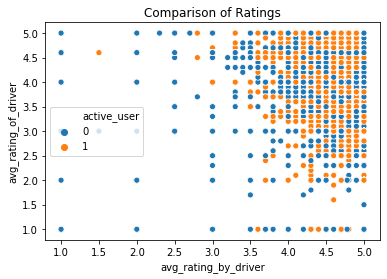

In [133]:
sns.scatterplot(ultimate_data_df.avg_rating_by_driver, ultimate_data_df.avg_rating_of_driver, \
           hue=ultimate_data_df.active_user)
plt.title('Comparison of Ratings')

In general, there are very few users retained who were given a rating of 3 or below by the driver. More users remained active after rating their driver at 3 or below, however.

# Building a predictive model

In [134]:
ultimate_data_df.signup_date.min(), ultimate_data_df.last_trip_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

In [135]:
ultimate_data_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,0.37708,60.926084,0.376080
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,0.48466,37.081503,0.484405
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,0.00000,66.700000,0.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,1.00000,100.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,1.00000,100.000000,1.000000


Will consider that I may need to standardize values for the predictive model. Begin with random forest.

In [136]:
ultimate_data_df.head(6)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,0
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,1,100.0,1


In [137]:
#convert datetime values to days after min date value
last_trip_date_min = ultimate_data_df.last_trip_date.min()
signup_date_min = ultimate_data_df.signup_date.min()

# Convert the date into a number (of days since some point)

ultimate_data_df['last_trip_timedelta'] = (ultimate_data_df['last_trip_date'] - \
                                           last_trip_date_min).dt.days.astype(int)
print(ultimate_data_df[['last_trip_date', 'last_trip_timedelta']].head())
ultimate_data_df.drop('last_trip_date', axis = 1, inplace = True)

ultimate_data_df['signup_timedelta'] = (ultimate_data_df['signup_date'] - \
                                           signup_date_min).dt.days.astype(int)
print(ultimate_data_df[['signup_date', 'signup_timedelta']].head(6))
ultimate_data_df.drop('signup_date', axis = 1, inplace = True)

  last_trip_date  last_trip_timedelta
0     2014-06-17                  167
1     2014-05-05                  124
2     2014-01-07                    6
3     2014-06-29                  179
4     2014-03-15                   73
  signup_date  signup_timedelta
0  2014-01-25                24
1  2014-01-29                28
2  2014-01-06                 5
3  2014-01-10                 9
4  2014-01-27                26
5  2014-01-09                 8


In [138]:
#one hot encode categorical data
ultimate_data_df_enc = pd.get_dummies(ultimate_data_df, columns=['city', 'phone'], prefix=['city', 'phone'])

In [139]:
#check it out
ultimate_data_df_enc.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user,last_trip_timedelta,signup_timedelta,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,1,167,24,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,0,124,28,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0,6,5,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,1,179,9,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,73,26,0,0,1,1,0


In [140]:
#select all columns EXCEPT the target variable column, which is active_user
#also remove last_trip_timedelta
cols = ultimate_data_df_enc.columns.tolist()
cols2 = cols[:8] + cols[10:]
cols2

['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'trips_in_first_30_days',
 'ultimate_black_user',
 'weekday_pct',
 'signup_timedelta',
 'city_Astapor',
 "city_King's Landing",
 'city_Winterfell',
 'phone_Android',
 'phone_iPhone']

In [141]:
#assign X and y - y first or there will be no 'active_user' column!
y = ultimate_data_df_enc['active_user']
X = ultimate_data_df_enc[cols2]

In [142]:
X[:5]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,signup_timedelta,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,24,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,28,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,5,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,9,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,26,0,0,1,1,0


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [144]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=27)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [145]:
y_pred=clf.predict(X_test)

In [146]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7648


In [147]:
#What features are important
feature_imp = pd.Series(clf.feature_importances_,index=cols2).sort_values(ascending=False)
feature_imp


avg_dist                  0.210009
signup_timedelta          0.135905
weekday_pct               0.116369
avg_rating_by_driver      0.109785
surge_pct                 0.077844
avg_rating_of_driver      0.072774
trips_in_first_30_days    0.072255
avg_surge                 0.061708
city_King's Landing       0.044149
ultimate_black_user       0.031725
phone_iPhone              0.019545
city_Astapor              0.017566
phone_Android             0.017184
city_Winterfell           0.013184
dtype: float64

avg_distance has the highest weight, and is also the column that contains the largest values. and I was concerned this might have too large an effect on the model.

In [148]:
#Normalizing avg_dist
ultimate_data_df_enc['avg_dist'] = (ultimate_data_df_enc['avg_dist'] - \
(ultimate_data_df_enc['avg_dist']).min()) / np.ptp(ultimate_data_df_enc['avg_dist'])

/Users/gene/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [149]:
ultimate_data_df_enc['avg_dist'][:5]

0    0.022801
1    0.051317
2    0.004784
3    0.014662
4    0.019446
Name: avg_dist, dtype: float64

In [150]:
#refresh variable X
X = ultimate_data_df_enc[cols2]

In [151]:
#redo splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [152]:
#run again
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=27)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [153]:
y_pred=clf.predict(X_test)

In [154]:
# Model Accuracy, how often is the classifier correct?
print(f"Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(f"Confusion matrix: \n{metrics.confusion_matrix(y_test, y_pred)}")

Accuracy: 0.7647
Confusion matrix: 
[[5219 1011]
 [1342 2428]]


In [155]:
feature_imp = pd.Series(clf.feature_importances_,index=cols2).sort_values(ascending=False)
feature_imp

avg_dist                  0.210009
signup_timedelta          0.135905
weekday_pct               0.116369
avg_rating_by_driver      0.109785
surge_pct                 0.077844
avg_rating_of_driver      0.072774
trips_in_first_30_days    0.072255
avg_surge                 0.061708
city_King's Landing       0.044149
ultimate_black_user       0.031725
phone_iPhone              0.019545
city_Astapor              0.017566
phone_Android             0.017184
city_Winterfell           0.013184
dtype: float64

No handles with labels found to put in legend.


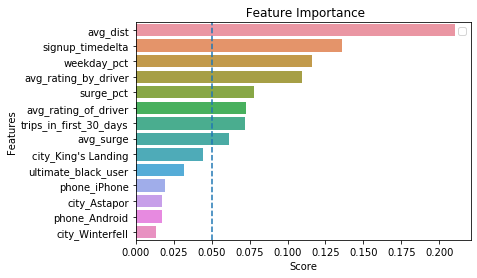

In [156]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Score')
plt.ylabel('Features')
plt.title(" Feature Importance")
plt.axvline(0.05, linestyle='dashed')
plt.legend()


Text(0.5, 1.0, 'Two most heavily weighted factors')

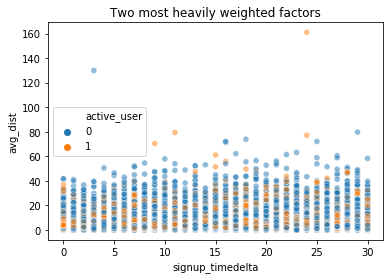

In [177]:
sns.scatterplot(ultimate_data_df.signup_timedelta, ultimate_data_df.avg_dist, \
               hue=ultimate_data_df.active_user, alpha=0.5)
plt.title('Two most heavily weighted factors')

Plotting the two most heavily weighted factors. It appears as though the users who are still active (toward the rh side of the chart) had longer average trips in their first 30 days.

The above classification was done just using default parameters on the features we prepared from the original dataframe. Let's see if we can do better using a gred search.

In [167]:
param_grid = {'n_estimators':[100,200,300, 400],
              'max_leaf_nodes':[2,5, 10, 20]}

In [168]:
clf=RandomForestClassifier(random_state=27) # remove estimators since setting with param_grid

In [169]:
rf_grid = GridSearchCV(clf, param_grid = param_grid, cv=5)

In [170]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=27,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [171]:
print(f'Best Score: {rf_grid.best_score_}')
print(f'Best Parameters {rf_grid.best_params_}')
print(f'Confusion matrix {rf_grid.best_estimator_}')

Best Score: 0.774425
Best Parameters {'max_leaf_nodes': 20, 'n_estimators': 300}
Confusion matrix RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)


The predictive model I chose was a random forest classifier. I chose this as the first model as, among other things, it accepts both categorical and continuous variables, avoids the overfitting problem due to averaging individual predictions, and also has a good feature variable indicator. It is insensitive to the magnitude of the data, so normalizing or standardizing is not necessary. In fact, the 'avg_dist' columns above was normalized between different runs just to confirm, and the results were very similar.

Out of the box the classifier had an accuracy of 75%. This improved to 77% when parameters were optimized via a grid search. The four most important features determined were average distance, signup date, the percent of trips during a weekday and the average rating by the driver.

Some caveats to consider include the imputed data for average ratings, and the type of cell phone used. This would be of more concern, however, if these features contributed higher importance to the model.

Ultimate might leverage these data to improve their long-term rider retention by encouraging new members to take longer trips in their first 30 days. It also appears as though users remain active longer when receiving better ratings from the drivers. Trips taken while the surge multiplier is > 1 is also to be encouraged.